In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

from nltk.tokenize import word_tokenize          
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')

import string

from IPython.core.display import display, HTML

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


# Data Exploration Objectives

* Get the essay length in words
* Find all stopwords and non-stopwords
* Build a ratio of the percentage of stopwords to non-stopwords (i.e. stopwords / essay length)
* Build a metric for average length of words
* Build a metric for average length of sentences
* Get an overall average score across the 6 categories
* Find the average distribution for each category (i.e. histogram)
* Prune the data to remove fields like text_id due to max cardinality

In [2]:
csv = "/kaggle/input/feedback-prize-english-language-learning/train.csv"
df = pd.read_csv(csv)
df.shape

(3911, 8)

In [3]:
df.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


### Get the average length of each sentence

In [4]:
avg_sentence_length = []
for entry in df["full_text"]:
    lengths = [len(sentence) for sentence in entry.split(".")]
    average = sum(lengths) / len(lengths)
    avg_sentence_length.append(average)
df = df.assign(avg_sentence_length=avg_sentence_length)

### Get the essay length in words

In [5]:
lengths = [len(entry.split(" ")) for entry in df["full_text"]]
df = df.assign(essay_length=lengths)

### Show all unique scores for each category

In [6]:
for column in ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]:
    print(f"{column}: ", sorted(list(df[f"{column}"].unique())))

cohesion:  [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
syntax:  [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
vocabulary:  [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
phraseology:  [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
grammar:  [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
conventions:  [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


### Build a counter for the categories so we can plot a history of total scores per category

In [7]:
def count_elements(seq) -> dict:
    """Tally elements from `seq`."""
    hist = {}
    for i in seq:
        hist[i] = hist.get(i, 0) + 1
    return hist

conventions = count_elements(df["conventions"])
cohesion = count_elements(df["cohesion"])
syntax = count_elements(df["syntax"])
vocabulary = count_elements(df["vocabulary"])
phraseology = count_elements(df["phraseology"])
grammar = count_elements(df["grammar"])

### Understand the distribution of scores for each category

We see 3.0 as the most commonly occurring score through all categories. This gives us the ability to create three categories of Needs Improvement (N < 3), Meets Expectations (4 > N >= 3), and Exceeds Expectations (N >= 4).  

Text(0.5, 1.0, 'Grammar')

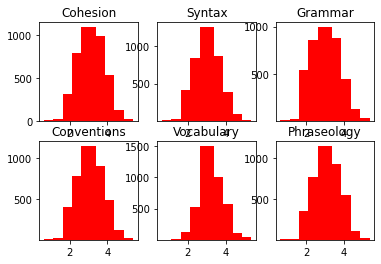

In [8]:
width = .75
height = .75
fig, axs = plt.subplots(2, 3)
axs[0, 0].bar(cohesion.keys(), cohesion.values(), width, color="r", label='cohesion')
axs[0, 0].set_title('Cohesion')
axs[0, 1].bar(syntax.keys(), syntax.values(), width, height, color="r", label='syntax')
axs[0, 1].set_title('Syntax')
axs[1, 0].bar(conventions.keys(), conventions.values(), width, height, color="r", label='conventions')
axs[1, 0].set_title('Conventions')
axs[1, 1].bar(vocabulary.keys(), vocabulary.values(), width, height, color="r", label='vocabulary')
axs[1, 1].set_title('Vocabulary')
axs[1, 2].bar(phraseology.keys(), phraseology.values(), width, height, color="r", label='phraseology')
axs[1, 2].set_title('Phraseology')
axs[0, 2].bar(grammar.keys(), grammar.values(), width, height, color="r", label='grammar')
axs[0, 2].set_title('Grammar')

### Build the overall average across categories

In [9]:
overall_average = []
for index, entry in df.iterrows():
    average = sum([entry["cohesion"],entry["syntax"],entry["vocabulary"],entry["phraseology"],entry["grammar"],entry["conventions"]]) / 6
    overall_average.append(average)
df = df.assign(overall_average=overall_average)

### Lemmatize the words in the essays

We will start by counting the number of stop words (e.g. a, an, the, is) vs non-stop words.

In [10]:
class LemmaTokenizer:
    """Interface to the WordNet lemmatizer from nltk"""
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]

In [11]:
tokenizer=LemmaTokenizer()
token_stop = tokenizer(' '.join(stop_words))
vectorizer = TfidfVectorizer(stop_words=token_stop, tokenizer=tokenizer)

### Categorized scoring based on three values

We can look at the overall scores as a whole to determine how frequently the overall average is below or above a certain threshold. Building the overall score shows a consistent trend between each score.

In [12]:
score_outcome = []
for entry in df["overall_average"]:
    if entry < 3.0: score_outcome.append("Needs Improvement")
    elif entry >= 4.0: score_outcome.append("Exceeds Expectations")
    else: score_outcome.append("Meets Expectations")
df = df.assign(score_outcome=score_outcome)

In [13]:
exceeds_word_count = df[(df["score_outcome"] == "Exceeds Expectations")]["essay_length"].mean()
meets_expectations_word_count = df[(df["score_outcome"] == "Meets Expectations")]["essay_length"].mean()
needs_improvment_word_count = df[(df["score_outcome"] == "Needs Improvement")]["essay_length"].mean()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='score_outcome', ylabel='count'>

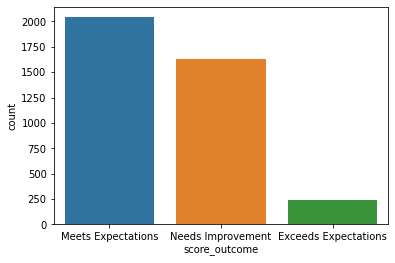

In [14]:
import seaborn as sns

sns.countplot(df["score_outcome"], label="Total")

We can see here that the number of above average scores is very rare. The groupby function below proves this. If an essay scores a 1.0 in grammar, this individual is much more likely to score lower in the remaining 6 categories. This trend continues consistently as the scores rise. 

In [15]:
from tqdm import tqdm

total_stopwords = []
total_non_stopwords = []
unique_words = []
for entry in tqdm(df["full_text"]):
    total_stopwords.append(len([word for word in entry.split(" ") if word in stopwords.words('english')]))
    total_non_stopwords.append(len([word for word in entry.split(" ") if word not in stopwords.words('english')]))
    unique_words.append(len(set(entry.split(" "))))
df = df.assign(total_stopwords=total_stopwords)
df = df.assign(total_non_stopwords=total_non_stopwords)
df = df.assign(unique_words=unique_words)

100%|██████████| 3911/3911 [06:18<00:00, 10.35it/s]


In [16]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
punctuation = []
for entry in tqdm(df["full_text"]):
    punctuation.append(count(entry,set(string.punctuation)))
df = df.assign(punctuation=punctuation)

100%|██████████| 3911/3911 [00:00<00:00, 9743.22it/s]


In [17]:
df.groupby("grammar").mean()

,cohesion,syntax,vocabulary,phraseology,conventions,avg_sentence_length,essay_length,overall_average,total_stopwords,total_non_stopwords,unique_words,punctuation
grammar,,,,,,,,,,,,
1.0,1.250000,1.187500,1.437500,1.250000,1.250000,175.516278,741.125000,1.229167,179.625000,561.500000,139.250000,27.375000
1.5,1.625000,1.600000,1.850000,1.775000,1.575000,299.247012,680.600000,1.654167,204.550000,476.050000,148.850000,24.500000
2.0,2.539522,2.390625,2.698529,2.443934,2.465993,176.965513,469.533088,2.423100,209.582721,259.950368,155.305147,36.560662
2.5,2.791813,2.671345,2.934503,2.752047,2.726316,159.575832,443.334503,2.729337,202.640936,240.693567,161.429240,37.581287
3.0,3.134809,3.032696,3.266600,3.103119,3.075956,147.115619,466.039235,3.102197,215.663984,250.375252,174.467807,40.774648
3.5,3.413068,3.323295,3.482955,3.451136,3.368750,130.237908,457.401136,3.423201,214.789773,242.611364,180.332955,41.939773
4.0,3.625280,3.554810,3.629754,3.678971,3.626398,120.187542,438.545861,3.685869,202.532438,236.013423,179.552573,42.239374
4.5,4.130597,4.186567,4.227612,4.227612,4.208955,114.960373,531.835821,4.246891,234.567164,297.268657,216.694030,52.149254
5.0,4.327586,4.431034,4.431034,4.465517,4.448276,122.878107,565.896552,4.517241,241.724138,324.172414,225.413793,59.344828


In [18]:
output = []
headers = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]
for column in headers:
    for entry in headers: output.append(f"{column}+{entry}")

### Assessing grammar first

We will begin by finding ways to extract grammatical errors from the text. The intent of this practice is to determine a correlation between the radio of grammatical errors and the grammar score. Other data points like unique words, total punctuation counts, and essay length will be factored into the model. 

An open source toolset called `language_tool_python` can extract grammatical errors of different types from a string of text. Source: https://pypi.org/project/language-tool-python/

In [19]:
!pip install language_tool_python

In [20]:
import language_tool_python
tool = language_tool_python.LanguageTool('en-US')

total_grammatical_errors = []
unique_grammatical_errors = []
for entry in tqdm(df["full_text"]):
    matches = tool.check(entry)
    # unique grammatical errors
    unique_grammatical_errors.append(len(set([rule.ruleId for rule in matches])))
    # total grammatical errors
    total_grammatical_errors.append(len(matches))

df = df.assign(total_grammatical_errors=total_grammatical_errors)
df = df.assign(unique_grammatical_errors=unique_grammatical_errors)

100%|██████████| 3911/3911 [10:16<00:00,  6.35it/s]


### Grammar score and grammatical errors correlation

It appears the number of grammatical errors consistently declines on average as the score increases.

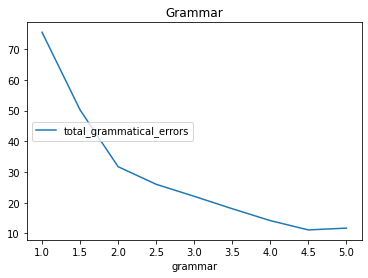

In [21]:
plt = df.groupby("grammar").mean()["total_grammatical_errors"].plot(legend=True)
plt.set_title("Grammar")
plt.legend(loc="center left")

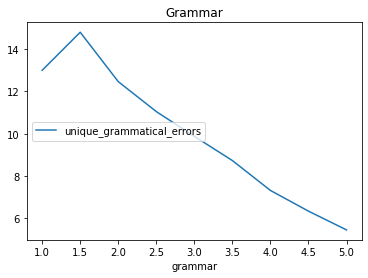

In [22]:
plt = df.groupby("grammar").mean()["unique_grammatical_errors"].plot(legend=True)
plt.set_title("Grammar")
plt.legend(loc="center left")

In [23]:
grammatical_errors_ratio = []
for index, entry in df.iterrows():
    ratio = entry["total_grammatical_errors"] / entry["essay_length"]
    grammatical_errors_ratio.append(ratio)
df = df.assign(grammatical_errors_ratio=grammatical_errors_ratio)

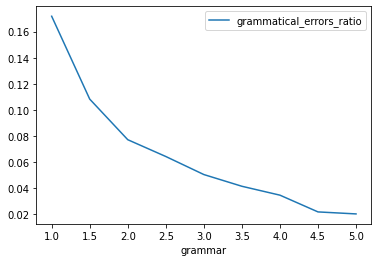

In [24]:
plt = df.groupby("grammar").mean()["grammatical_errors_ratio"].plot(legend=True)

### Other consistent trends

* Consistent trending outputs for grammer include punctuation, unique words, and the use of stopwords.

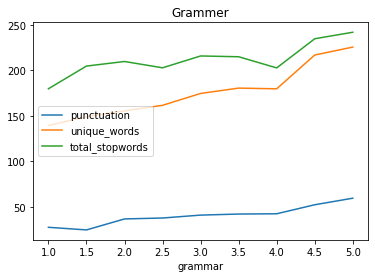

In [25]:
plt = df.groupby("grammar").mean()["punctuation"].plot(legend=True)
plt = df.groupby("grammar").mean()["unique_words"].plot(legend=True)
plt = df.groupby("grammar").mean()["total_stopwords"].plot(legend=True)
plt.set_title("Grammer")
plt.legend(loc="center left")

### Analyze the text for sentiment

This is an experimental approach to discover if there is a positive correlation between scores and overall sentiment.

In [26]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
df[['neg', 'neu', 'pos', 'compound']] = df['full_text'].apply(sid.polarity_scores).apply(pd.Series)

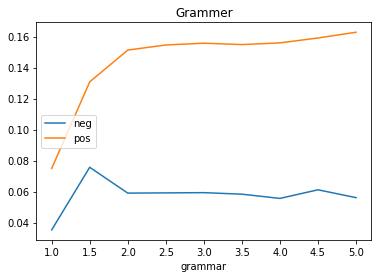

In [27]:
plt = df.groupby("grammar").mean()["neg"].plot(legend=True)
plt = df.groupby("grammar").mean()["pos"].plot(legend=True)
plt.set_title("Grammer")
plt.legend(loc="center left")

### Create a training set for grammar

In [28]:
grammar_train = df.copy()
grammar_train = grammar_train[["grammar", "total_stopwords", "unique_words", "punctuation", "neg", "pos", "total_grammatical_errors", "unique_grammatical_errors", "grammatical_errors_ratio", "essay_length"]]

### Create test and train datasets

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(grammar_train.loc[:, grammar_train.columns != "grammar"], grammar_train["grammar"], stratify=grammar_train["grammar"],test_size=0.25, random_state=66)

### K nearest neighbor regression model

We are going to train our model using the data points with favorable correlations and trends

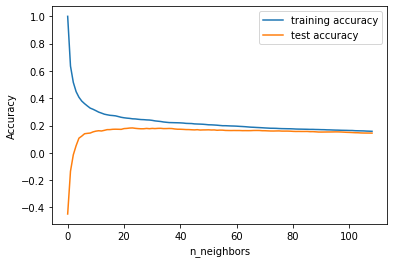

In [30]:
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

training_accuracy = []
test_accuracy = []

neighbors = range(1, 110)

for neighbor in neighbors:
    knn = KNeighborsRegressor(n_neighbors=neighbor)
    knn.fit(X_train, y_train)
    knn_prediction = knn.predict(X_test)
    training_accuracy.append(knn.score(X_train, y_train))
    test_accuracy.append(knn.score(X_test, y_test))

plt.plot(training_accuracy, label="training accuracy")
plt.plot(test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.savefig("knn_regression_model")

In [31]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=20)
knn.fit(X_train, y_train)
knn_prediction = knn.predict(X_test)
knn.score(X_test, y_test)

0.17208467749714362

### Random forest

We are going to train our model using the data points with favorable correlations and trends

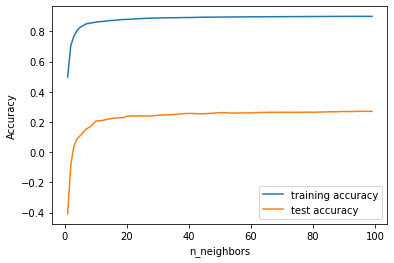

In [32]:
from sklearn.ensemble import RandomForestRegressor

training_accuracy = []
test_accuracy = []

estimators = range(1, 100)

for n_estimators in estimators:
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state = 0)
    rf.fit(X_train, y_train)
    rf_prediction = rf.predict(X_test)
    training_accuracy.append(rf.score(X_train, y_train))
    test_accuracy.append(rf.score(X_test, y_test))

plt.plot(estimators, training_accuracy, label="training accuracy")
plt.plot(estimators, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.savefig("rf_regression_model")

In [33]:
rf = RandomForestRegressor(n_estimators = 95, random_state = 0)
rf.fit(X_train, y_train)
rf_prediction = rf.predict(X_test)
rf.score(X_test, y_test)

0.2705448258013282

### Gradient boost

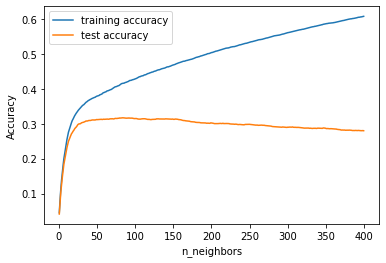

In [34]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

training_accuracy = []
test_accuracy = []

estimators = range(1, 400)

for n_estimators in estimators:
    gbr = GradientBoostingRegressor(n_estimators=n_estimators, random_state=0)
    gbr.fit(X_train, y_train)
    gbr.predict(X_test)
    gbr.score(X_test, y_test)
    training_accuracy.append(gbr.score(X_train, y_train))
    test_accuracy.append(gbr.score(X_test, y_test))

plt.plot(estimators, training_accuracy, label="training accuracy")
plt.plot(estimators, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.savefig("gb_regression_model")

In [35]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=90, random_state=0)
gbr.fit(X_train, y_train)
gbr.predict(X_test)
gbr.score(X_test, y_test)

0.31628592783762133

### Add a function for rounding to the nearest number in the prediction

In [36]:
import numpy as np

def closest(K):
     lst = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return lst[idx]

In [37]:
# Make a copy of the output and dump it to a separate dataframe
grammar_output = X_test.copy()
grammar_original = grammar_train.copy()
grammar_output["knn_prediction"] = knn_prediction
grammar_output["rf_prediction"] = rf_prediction
grammar_output["gbr_prediction"] = rf_prediction

grammar_inner = pd.merge(grammar_output, grammar_original, left_index=True, right_index=True)

# Provide output in the same table for viewing and evaluation
knn_adjusted_score = [closest(entry) for entry in grammar_inner["knn_prediction"]]
grammar_inner = grammar_inner.assign(knn_adjusted_score=knn_adjusted_score)
grammar_inner["knn_differential_adjusted"] = grammar_inner["knn_adjusted_score"] - grammar_inner["grammar"]
grammar_inner["knn_differential"] = grammar_inner["knn_prediction"] - grammar_inner["grammar"]

# Provide output in the same table for viewing and evaluation
rf_adjusted_score = [closest(entry) for entry in grammar_inner["rf_prediction"]]
grammar_inner = grammar_inner.assign(rf_adjusted_score=rf_adjusted_score)
grammar_inner["rf_differential_adjusted"] = grammar_inner["rf_adjusted_score"] - grammar_inner["grammar"]
grammar_inner["rf_differential"] = grammar_inner["rf_prediction"] - grammar_inner["grammar"]

# Provide output in the same table for viewing and evaluation
gbr_adjusted_score = [closest(entry) for entry in grammar_inner["gbr_prediction"]]
grammar_inner = grammar_inner.assign(gbr_adjusted_score=gbr_adjusted_score)
grammar_inner["gbr_differential_adjusted"] = grammar_inner["gbr_adjusted_score"] - grammar_inner["grammar"]
grammar_inner["gbr_differential"] = grammar_inner["gbr_prediction"] - grammar_inner["grammar"]

In [38]:
grammar_inner["gbr_differential_adjusted"].value_counts()

 0.0    317
 0.5    232
-0.5    223
-1.0     95
 1.0     80
 1.5     17
-1.5     11
-2.0      2
 2.0      1
Name: gbr_differential_adjusted, dtype: int64

### Feature Importance

We will analyze the feature importance for Random Forest and Grandient Boost. Note: KNN Regressor does not offer this data. It appears the `grammatical_errors_ratio` data point provides the best feature for predicting grammar scores. Due to randomness in essay length, total grammatical errors alone does not give us good insight on whether grammar is above average. Unique words used in addition to the number of unique grammatical errors appears correlated to the model's prediction. This is possibly attributing an astute writer's range vocabulary to a level of advancement in various categories. In addition, the diversity of grammatical errors could indicate a user's consciousness of varying grammar rules. 

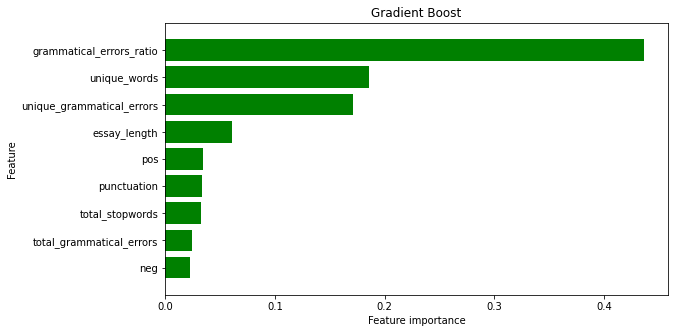

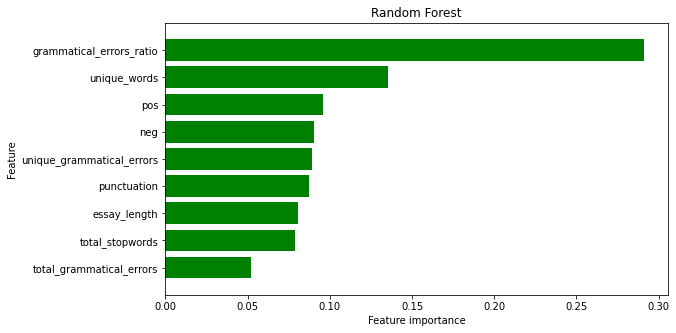

In [39]:
import matplotlib.pyplot as plt

for model in [gbr, rf]:
    entries = []
    for entry in sorted(model.feature_importances_):
        entries.append(list(model.feature_importances_).index(entry))
    features = [X_train.columns[entry] for entry in entries]
    plt.figure(figsize=(len(features),5))
    n_features = len(features)
    plt.barh(range(n_features), sorted(model.feature_importances_), align="center", color="green")
    plt.yticks(np.arange(n_features), features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    if model == gbr:
        plt.title("Gradient Boost")
    else:
        plt.title("Random Forest")

### Vocabulary Training

In [40]:
dataframes = {}
for entry in ["vocabulary", "cohesion", "phraseology", "syntax", "conventions", "grammar"]:
    features_ = [entry, "total_stopwords", "unique_words", "punctuation", "neg", "pos", "total_grammatical_errors", "unique_grammatical_errors", "grammatical_errors_ratio", "essay_length"]
    placeholder = df.copy()
    placeholder = placeholder[features_]
    dataframes[entry] = placeholder

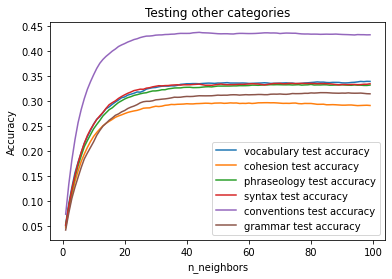

In [41]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

for key, value in dataframes.items():
    X_train, X_test, y_train, y_test = train_test_split(value.loc[:, value.columns != key], value[key], stratify=value[key],test_size=0.25, random_state=66)
    training_accuracy = []
    test_accuracy = []

    estimators = range(1, 100)

    for n_estimators in estimators:
        gbr = GradientBoostingRegressor(n_estimators=n_estimators, random_state=0)
        gbr.fit(X_train, y_train)
        gbr.predict(X_test)
        gbr.score(X_test, y_test)
        training_accuracy.append(gbr.score(X_train, y_train))
        test_accuracy.append(gbr.score(X_test, y_test))

    plt.plot(estimators, test_accuracy, label=f"{key} test accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("n_neighbors")
    plt.legend()
    plt.savefig("gb_regression_model")
    plt.title("Testing other categories")

In [42]:
feature_importances = {}
for key, value in dataframes.items():
    X_train, X_test, y_train, y_test = train_test_split(value.loc[:, value.columns != key], value[key], stratify=value[key],test_size=0.25, random_state=66)
    gbr = GradientBoostingRegressor(n_estimators=40, random_state=0)
    gbr.fit(X_train, y_train)
    gbr.predict(X_test)
    print(f"{key} score: {gbr.score(X_test, y_test)}")
    feature_importances[key] = gbr.feature_importances_

vocabulary score: 0.3350185066336717
cohesion score: 0.29492783427258285
phraseology score: 0.32787065385204206
syntax score: 0.3328885198857364
conventions score: 0.43586853376154255
grammar score: 0.30953330652897415


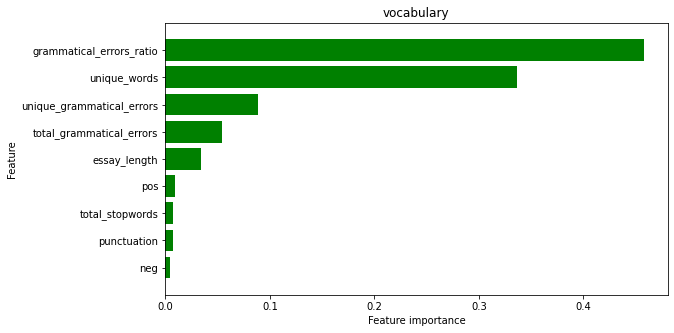

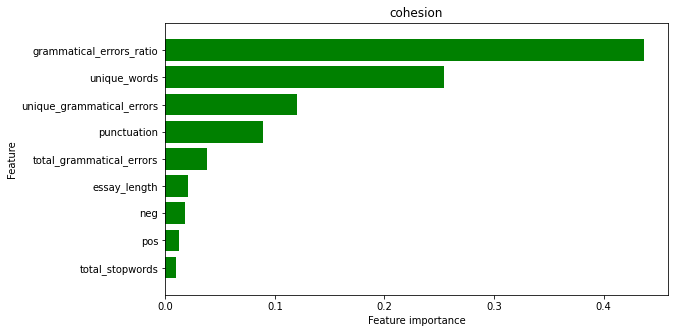

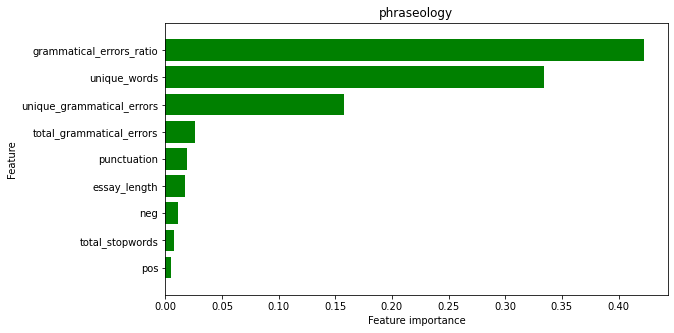

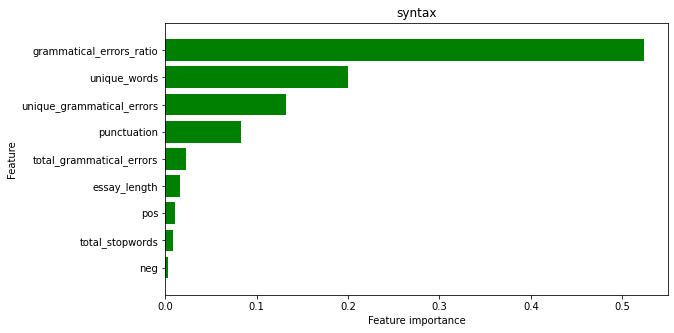

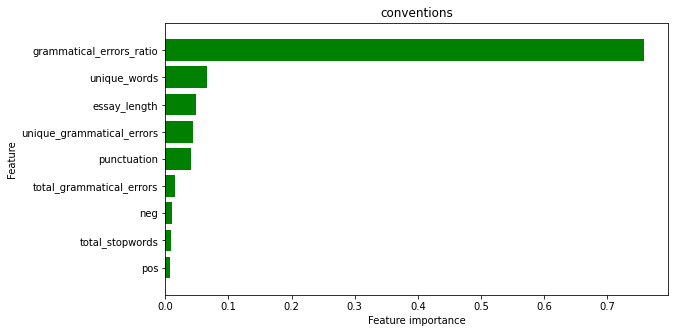

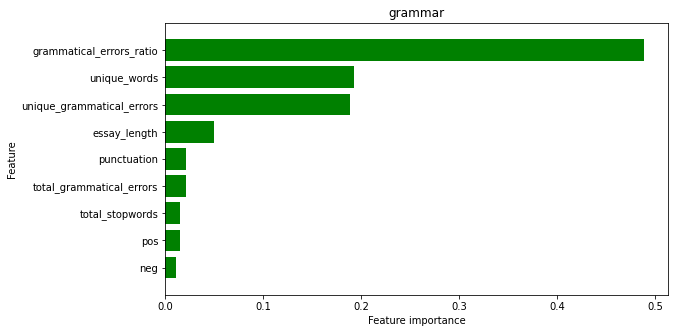

In [43]:
import matplotlib.pyplot as plt

for key, value in feature_importances.items():
    entries = []
    for entry in sorted(value):
        entries.append(list(value).index(entry))
    features = [X_train.columns[entry] for entry in entries]
    plt.figure(figsize=(len(features),5))
    n_features = len(features)
    plt.barh(range(n_features), sorted(value), align="center", color="green")
    plt.yticks(np.arange(n_features), features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.title(key)

In [44]:
custom_features = {}
custom_features["vocabulary"] = ["vocabulary", "grammatical_errors_ratio", "unique_words", "unique_grammatical_errors", "total_grammatical_errors", "essay_length"]
custom_features["cohesion"] = ["cohesion", "grammatical_errors_ratio", "unique_words", "unique_grammatical_errors", "punctuation", "total_grammatical_errors"]
custom_features["syntax"] = ["syntax", "grammatical_errors_ratio", "unique_words", "unique_grammatical_errors", "punctuation"]
custom_features["phraseology"] = ["phraseology", "grammatical_errors_ratio", "unique_words", "unique_grammatical_errors"]
custom_features["conventions"] = ["conventions", "grammatical_errors_ratio", "unique_words", "essay_length", "unique_grammatical_errors", "punctuation"]
custom_features["grammar"] = ["grammar", "grammatical_errors_ratio", "unique_words", "unique_grammatical_errors", "punctuation", "essay_length"]

In [45]:
import pickle

feature_importances = {}
for key, value in dataframes.items():
    value = value[custom_features[key]]
    value.head()
    X_train, X_test, y_train, y_test = train_test_split(value.loc[:, value.columns != key], value[key], stratify=value[key],test_size=0.25, random_state=66)
    gbr = GradientBoostingRegressor(n_estimators=40, random_state=0)
    gbr.fit(X_train, y_train)
    gbr.predict(X_test)
    print(f"{key} score: {gbr.score(X_test, y_test)}")
    filename = f"/kaggle/working/{key}.sav"
    pickle.dump(gbr, open(filename, "wb"))

vocabulary score: 0.3310142873027919
cohesion score: 0.29332764371155984
phraseology score: 0.32357830317468617
syntax score: 0.3278143624541885
conventions score: 0.43461881531051627
grammar score: 0.3030381161324621


In [46]:
# Import file and make dataframe
readfile = "/kaggle/input/feedback-prize-english-language-learning/test.csv"
readdata = pd.read_csv(readfile)

# Get average sentence length and essay length
avg_sentence_length = []
for entry in readdata["full_text"]:
    lengths = [len(sentence) for sentence in entry.split(".")]
    average = sum(lengths) / len(lengths)
    avg_sentence_length.append(average)
readdata = readdata.assign(avg_sentence_length=avg_sentence_length)
lengths = [len(entry.split(" ")) for entry in readdata["full_text"]]
readdata = readdata.assign(essay_length=lengths)

# Get stopwords, non-stopwords, and unique words
total_stopwords = []
total_non_stopwords = []
unique_words = []
for entry in readdata["full_text"]:
    total_stopwords.append(len([word for word in entry.split(" ") if word in stopwords.words('english')]))
    total_non_stopwords.append(len([word for word in entry.split(" ") if word not in stopwords.words('english')]))
    unique_words.append(len(set(entry.split(" "))))
readdata = readdata.assign(total_stopwords=total_stopwords)
readdata = readdata.assign(total_non_stopwords=total_non_stopwords)
readdata = readdata.assign(unique_words=unique_words)

# Count the punctuation errors
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
punctuation = []
for entry in readdata["full_text"]:
    punctuation.append(count(entry,set(string.punctuation)))
readdata = readdata.assign(punctuation=punctuation)

# Count the grammatical errors
# Assign the total and a ratio
import language_tool_python
tool = language_tool_python.LanguageTool('en-US')
total_grammatical_errors = []
unique_grammatical_errors = []
for entry in readdata["full_text"]:
    matches = tool.check(entry)
    # unique grammatical errors
    unique_grammatical_errors.append(len(set([rule.ruleId for rule in matches])))
    # total grammatical errors
    total_grammatical_errors.append(len(matches))
readdata = readdata.assign(total_grammatical_errors=total_grammatical_errors)
readdata = readdata.assign(unique_grammatical_errors=unique_grammatical_errors)
grammatical_errors_ratio = []
for index, entry in readdata.iterrows():
    ratio = entry["total_grammatical_errors"] / entry["essay_length"]
    grammatical_errors_ratio.append(ratio)
readdata = readdata.assign(grammatical_errors_ratio=grammatical_errors_ratio)

# Grab sentinment from the text
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
readdata[['neg', 'neu', 'pos', 'compound']] = readdata['full_text'].apply(sid.polarity_scores).apply(pd.Series)

dataframes_list = {}
for entry in ["vocabulary", "cohesion", "phraseology", "syntax", "conventions", "grammar"]:
    features_ = ["total_stopwords", "unique_words", "punctuation", "neg", "pos", "total_grammatical_errors", "unique_grammatical_errors", "grammatical_errors_ratio", "essay_length"]
    placeholder = readdata.copy()
    placeholder = placeholder[features_]
    dataframes_list[entry] = placeholder

custom_features = {}
custom_features["vocabulary"] = ["grammatical_errors_ratio", "unique_words", "unique_grammatical_errors", "total_grammatical_errors", "essay_length"]
custom_features["cohesion"] = ["grammatical_errors_ratio", "unique_words", "unique_grammatical_errors", "punctuation", "total_grammatical_errors"]
custom_features["syntax"] = ["grammatical_errors_ratio", "unique_words", "unique_grammatical_errors", "punctuation"]
custom_features["phraseology"] = ["grammatical_errors_ratio", "unique_words", "unique_grammatical_errors"]
custom_features["conventions"] = ["grammatical_errors_ratio", "unique_words", "essay_length", "unique_grammatical_errors", "punctuation"]
custom_features["grammar"] = ["grammatical_errors_ratio", "unique_words", "unique_grammatical_errors", "punctuation", "essay_length"]

In [47]:
for key, value in dataframes_list.items():
    value = value[custom_features[key]]
    loaded_model = pickle.load(open(f"{key}.sav", "rb"))
    predict_data = loaded_model.predict(value)
    adjusted_score = [closest(entry) for entry in predict_data]
    readdata = readdata.assign(temp_prediction=adjusted_score)
    readdata = readdata.rename(columns={"temp_prediction": key})

In [48]:
readdata = readdata[["text_id", "cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]]

In [49]:
readdata.to_csv("/kaggle/working/submission.csv")